### Notebook Overview

1. **Preprocessing Images**:
   - The images in the dataset come in different sizes. We will preprocess them by cropping to dimensions divisible by 256 to ensure uniformity.

2. **Handling Mask Colors**:
   - The mask images contain HEXA codes that need to be converted to RGB format for proper representation.

3. **One-Hot Encoding**:
   - Since this is a multi-class segmentation problem, we will convert the RGB values into one-hot encoded format for model training.

4. **Reconversion of Predicted Images**:
   - After prediction, the images will need to be converted back to their original RGB colors.

We will use the **patchify** library for image cropping and extracting patches. The patch size will be (256, 256), meaning we need to divide the original images into tiles of (n_rows, n_cols) that are divisible by 256.

The **U-Net architecture** will be implemented for this segmentation problem using TensorFlow's Keras API.

In [20]:
# Importing required libraries
!pip install patchify

# Standard libraries
from pathlib import Path
from patchify import patchify
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow and Keras libraries
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import (
    Input, 
    Conv2D, 
    BatchNormalization, 
    ReLU, 
    SpatialDropout2D, 
    MaxPooling2D, 
    Conv2DTranspose, 
    concatenate
)

# Metrics and Loss functions
from tensorflow.keras.metrics import OneHotIoU, Recall, Precision
from tensorflow.keras.losses import CategoricalFocalCrossentropy, Dice
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
import numpy as np
import cv2
from pathlib import Path
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import tensorflow as tf

# Training Dataset: semantic-segmentation-of-aerial-imagery
train_dataset_path = Path('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1')

# Testing Dataset: satellite-image-and-mask
test_dataset_path = Path('/kaggle/input/satellite-image-and-mask')

patch_size = 256
scaler = MinMaxScaler()

# Function to preprocess dataset
def preprocess_images_masks(image_paths, mask_paths, patch_size=256, num_classes=6):
    image_dataset, mask_dataset = [], []

    for image_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        # Resize images and masks
        x_size = (image.shape[1] // patch_size) * patch_size
        y_size = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image).crop((0, 0, x_size, y_size))
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))

        image = np.array(image)
        mask = np.array(mask)

        # Create patches
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :][0]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                single_patch_mask = patches_mask[i, j, :, :][0]

                image_dataset.append(single_patch_img)
                mask_dataset.append(single_patch_mask)

    X = np.array(image_dataset)
    Y = np.array(mask_dataset)
    Y = np.where(Y >= num_classes, num_classes - 1, Y)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)

    return X, Y

# Prepare training data
train_image_paths = sorted((train_dataset_path / 'images').glob('*.jpg'))
train_mask_paths = sorted((train_dataset_path / 'masks').glob('*.png'))
X_train, Y_train = preprocess_images_masks(train_image_paths, train_mask_paths)

# Prepare testing data
test_image_paths = sorted((test_dataset_path / 'test_image').glob('*.png'))
test_mask_paths = sorted((test_dataset_path / 'test_mask').glob('*.png'))
X_test, Y_test = preprocess_images_masks(test_image_paths, test_mask_paths)

# Verify shapes
print(f'Training data shape: {X_train.shape}, {Y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {Y_test.shape}')

Training data shape: (54, 256, 256, 3), (54, 256, 6)
Testing data shape: (0,), (0, 6)


In [22]:
from pathlib import Path

# Define the directory containing dataset
directory = Path('/kaggle/input/semantic-segmentation-of-aerial-imagery')

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  # List all png masks in sorted order
    print(f'Found masks in: {path.name}')


Found masks in: masks
Found masks in: masks
Found masks in: masks
Found masks in: masks
Found masks in: masks
Found masks in: masks
Found masks in: masks
Found masks in: masks


In [23]:
# Define the patch size and initialize the mask dataset
patch_size = 256
mask_dataset = []

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  # List all png masks in sorted order
    print(f'Found masks in: {path.name}')
    print([mask.name for mask in masks])

    for mask_path in masks:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_COLOR)

        if mask is None:
            print(f'Error loading mask: {mask_path}')
            continue  # Skip if the mask is not loaded properly

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        x_size = (mask.shape[1] // patch_size) * patch_size
        y_size = (mask.shape[0] // patch_size) * patch_size
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))
        mask = np.array(mask)

        # Extract patches from each mask with overlap
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

        # Append each single patch to the mask dataset
        for row in range(patches_mask.shape[0]):
            for col in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[row, col, :, :]

                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)


Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'imag

In [24]:
import numpy as np

# Initialize lists clearly
image_dataset = []
mask_dataset = []

# Example of appending data (this is normally done inside your preprocessing loop)
# image_dataset.append(your_image_array)
# mask_dataset.append(your_mask_array)

# After populating datasets, convert them into numpy arrays:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Check shapes
print(image_dataset.shape)
print(mask_dataset.shape)


(0,)
(0,)


In [25]:
# Check if datasets are populated
print(f"Number of images: {len(image_dataset)}")
print(f"Number of masks: {len(mask_dataset)}")

if len(image_dataset) == 0 or len(mask_dataset) == 0:
    print("Datasets are empty. Please verify preprocessing step.")
else:
    check_number = np.random.randint(0, len(image_dataset))
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_dataset[check_number])
    ax[0].set_title('Image')

    ax[1].imshow(mask_dataset[check_number], cmap='gray')
    ax[1].set_title('Mask')

    plt.show()


Number of images: 0
Number of masks: 0
Datasets are empty. Please verify preprocessing step.


In [26]:
# Define hexadecimal colors for each class
class_colors_hex = {
    'Building': '#3C1098',
    'Land': '#8429F6',
    'Road': '#6EC1E4',
    'Vegetation': '#FEDD3A',
    'Water': '#E2A929',
    'Unlabeled': '#9B9B9B'
}

# Function to convert hexadecimal colors to RGB integer values
def hex_to_int(hex_color):
    hex_color = hex_color.lstrip('#')  # Remove the '#' from the beginning
    return np.array(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))  # Convert to RGB

# Create a dictionary mapping class names to their RGB integer values
class_colors = {key: hex_to_int(value) for key, value in class_colors_hex.items()}

# Print the RGB values for each class
print(class_colors)


{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [27]:
# Function to convert RGB colors in the label masks to integer labels
def rgb_to_2D_label(label):
    """
    Convert RGB mask to integer labels based on predefined class colors.

    Args:
        label (np.ndarray): Input mask in RGB format.

    Returns:
        np.ndarray: Segmentation mask with integer labels.
    """
    # Initialize a label mask with zeros
    label_seg = np.zeros(label.shape[:-1], dtype=np.uint8)
    
    # Assign integer labels based on RGB values
    for idx, color in enumerate(class_colors.values()):
        label_seg[np.all(label == color, axis=-1)] = idx  # Match the color

    return label_seg

# Convert all masks in mask_dataset to integer labels
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])
labels = np.expand_dims(labels, axis=-1)
print(labels.shape)

# Display unique labels and the shape of the labels array
print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of the labels is: ", labels.shape)


(0, 1)
Unique labels in label dataset are:  []
Shape of the labels is:  (0, 1)


In [28]:
# Converting labels to categories using one-hot encoding
num_classes = len(class_colors)
labels_categ = to_categorical(labels, num_classes=num_classes)  

# Display the shape of the one-hot encoded labels
print("Shape of one-hot encoded labels:", labels_categ.shape)


Shape of one-hot encoded labels: (0, 6)


In [29]:
import numpy as np
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from PIL import Image

# Initialize scaler and dataset lists clearly
scaler = MinMaxScaler()
patch_size = 256

image_dataset = []
mask_dataset = []

# Clearly define dataset directories
image_paths = sorted(Path('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images').glob('*.jpg'))
mask_paths = sorted(Path('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/masks').glob('*.png'))

# Iterate clearly over images and masks
for image_path, mask_path in zip(image_paths, mask_paths):
    image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        continue  # Skip corrupted files

    # Resize images and masks to be divisible by patch_size
    x_size = (image.shape[1] // patch_size) * patch_size
    y_size = (image.shape[0] // patch_size) * patch_size

    image = Image.fromarray(image).crop((0, 0, x_size, y_size))
    mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))

    image = np.array(image)
    mask = np.array(mask)

    # Apply patchify clearly
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, 0, :, :, :]
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

            single_patch_mask = patches_mask[i, j, :, :]

            image_dataset.append(single_patch_img)
            mask_dataset.append(single_patch_mask)

# After loops, convert clearly to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Verify clearly
print('Images shape:', image_dataset.shape)
print('Masks shape:', mask_dataset.shape)


Images shape: (54, 256, 256, 3)
Masks shape: (54, 256, 256)


In [30]:
# Clearly ensure these are ready
print("image_dataset shape:", image_dataset.shape)
print("mask_dataset shape:", mask_dataset.shape)

# Define generators clearly
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_data_gen = ImageDataGenerator()
label_data_gen = ImageDataGenerator()

# Generator function explicitly
def data_generator(image_gen, label_gen, X, Y, batch_size=8):
    image_generator = image_gen.flow(X, batch_size=batch_size, seed=1)
    mask_generator = label_gen.flow(Y, batch_size=batch_size, seed=1)

    while True:
        img_batch = image_generator.next()
        mask_batch = mask_generator.next()
        yield img_batch, mask_batch

# Initialize the training generator clearly
train_generator = data_generator(image_data_gen, label_data_gen, image_dataset, mask_dataset, batch_size=8)


image_dataset shape: (54, 256, 256, 3)
mask_dataset shape: (54, 256, 256)


In [31]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation.
    """
    numerator = 2 * K.sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = K.sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - numerator / (denominator + K.epsilon())

def combined_dice_focal_loss(y_true, y_pred):
    """
    Combined Dice Loss and Focal Loss for multi-class segmentation.
    """
    focal_loss = CategoricalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return focal_loss + dice

In [32]:
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

metrics = [
    MeanIoU(num_classes=6),  # Replace '6' with the number of classes in your segmentation task
    Precision(),
    Recall()
]

In [34]:
import numpy as np

# Verify image dataset shape (already correct)
print('image_dataset shape:', image_dataset.shape)

# Explicitly convert labels_categ to NumPy array
labels_categ = np.array(labels_categ)
print('labels_categ shape:', labels_categ.shape)


image_dataset shape: (54, 256, 256, 3)
labels_categ shape: (0, 6)


In [35]:
import numpy as np
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from PIL import Image
import tensorflow as tf

scaler = MinMaxScaler()
patch_size = 256

image_dataset = []
mask_dataset = []

# Correct paths explicitly
image_paths = sorted(Path('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images').glob('*.jpg'))
mask_paths = sorted(Path('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/masks').glob('*.png'))

for image_path, mask_path in zip(image_paths, mask_paths):
    image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        continue

    # Resize clearly
    x_size = (image.shape[1] // patch_size) * patch_size
    y_size = (image.shape[0] // patch_size) * patch_size

    image = Image.fromarray(image).crop((0, 0, x_size, y_size))
    mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))

    image = np.array(image)
    mask = np.array(mask)

    # Patchify clearly
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, 0, :, :, :]
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

            single_patch_mask = patches_mask[i, j, :, :]

            image_dataset.append(single_patch_img)
            mask_dataset.append(single_patch_mask)

# Convert datasets to numpy arrays explicitly
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Convert mask labels explicitly into categorical encoding
num_classes = 6
mask_dataset = np.where(mask_dataset >= num_classes, num_classes - 1, mask_dataset)
labels_categ = tf.keras.utils.to_categorical(mask_dataset, num_classes=num_classes)

# Verify final shapes explicitly
print('Images shape:', image_dataset.shape)
print('Labels shape:', labels_categ.shape)


Images shape: (54, 256, 256, 3)
Labels shape: (54, 256, 256, 6)


In [36]:
from sklearn.model_selection import train_test_split

# Ensure 'image_dataset' and 'labels_categ' are defined correctly first:
print('image_dataset shape:', image_dataset.shape)
print('labels_categ shape:', labels_categ.shape)

# Initial 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(
    image_dataset, labels_categ, test_size=0.20, random_state=42
)

# 50-50 validation-test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Verify splits
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Validation shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')


image_dataset shape: (54, 256, 256, 3)
labels_categ shape: (54, 256, 256, 6)
Train shapes: (43, 256, 256, 3), (43, 256, 256, 6)
Validation shapes: (5, 256, 256, 3), (5, 256, 256, 6)
Test shapes: (6, 256, 256, 3), (6, 256, 256, 6)


# building a model using segmentation-models library

In [ ]:
def load_data(dataset_path, img_size=(256, 256)):
    images, masks = [], []
    image_folder = os.path.join(dataset_path, "images")
    mask_folder = os.path.join(dataset_path, "masks")

    if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
        print(f"Error: Directory structure not found in {dataset_path}")
        return np.array([]), np.array([])

    for img_name in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, img_name))
        if img is None:
            continue  # Skip if the image file is corrupt
        img = cv2.resize(img, img_size)
        images.append(img / 255.0)

        mask_name = img_name.replace(".jpg", "_mask.png")
        mask = cv2.imread(os.path.join(mask_folder, mask_name), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue  # Skip if the mask file is missing
        mask = cv2.resize(mask, img_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

In [ ]:
import os
import cv2
import numpy as np

def load_data(dataset_path, img_size=(256, 256)):
    images, masks = [], []

    # Automatically detect correct subfolder
    subfolders = os.listdir(dataset_path)
    dataset_subfolder = os.path.join(dataset_path, subfolders[0])  # Assuming first subfolder is correct
    print(f"Using dataset subfolder: {dataset_subfolder}")

    # Define paths for images and masks
    image_folder = os.path.join(dataset_subfolder, "images")
    mask_folder = os.path.join(dataset_subfolder, "masks")

    if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
        print(f"Error: Image or Mask folder not found in {dataset_subfolder}")
        return np.array([]), np.array([])

    # Load images and masks
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is missing or corrupted
        img = cv2.resize(img, img_size)
        images.append(img / 255.0)

        mask_name = img_name.replace(".jpg", "_mask.png")  # Adjust based on mask naming
        mask_path = os.path.join(mask_folder, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue  # Skip if mask is missing
        mask = cv2.resize(mask, img_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, img_size[0], img_size[1], 1)


In [ ]:
# Load datasets with updated function
X_train, Y_train = load_data("/kaggle/input/semantic-segmentation-of-aerial-imagery")
X_test, Y_test = load_data("/kaggle/input/semantic-drone-dataset")


In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, MaxPooling2D, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

batch_size = 1

# Define dataset paths
train_dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
test_dataset_path = "/kaggle/input/satellite-image-and-mask"

# Function to load images and masks dynamically
def load_data(dataset_path, image_subfolder, mask_subfolder, img_size=(256, 256)):
    images, masks = [], []
    
    image_folder = os.path.join(dataset_path, image_subfolder)
    mask_folder = os.path.join(dataset_path, mask_subfolder)
    
    if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
        print(f"❌ Missing 'images' or 'masks' folder in {dataset_path}")
        return np.array([]), np.array([])

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    print(f"📂 Processing {dataset_path} - Found {len(image_files)} images, {len(mask_files)} masks")

    for img_name in image_files:
        img_path = os.path.join(image_folder, img_name)
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(mask_folder, mask_name)

        if not os.path.exists(mask_path):
            print(f"⚠️ Warning: No mask found for {img_name} (Skipping)")
            continue

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img / 255.0)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    print(f"✅ Loaded {len(images)} images and {len(masks)} masks from {dataset_path}")
    return images, masks

# Load datasets
X_train, Y_train = [], []
tiles = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5", "Tile 6", "Tile 7", "Tile 8"]
for tile in tiles:
    images, masks = load_data(os.path.join(train_dataset_path, tile), "images", "masks")
    if images.shape[0] > 0:
        X_train.append(images)
        Y_train.append(masks)

X_train = np.concatenate(X_train, axis=0) if X_train else np.array([])
Y_train = np.concatenate(Y_train, axis=0) if Y_train else np.array([])

X_test, Y_test = load_data(test_dataset_path, "test_image", "test_mask")

num_classes = 6
Y_train[Y_train >= num_classes] = num_classes - 1
Y_test[Y_test >= num_classes] = num_classes - 1

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

print(f"🔹 Training Data Shape: {X_train.shape}, {Y_train.shape}")
print(f"🔹 Testing Data Shape: {X_test.shape}, {Y_test.shape}")

# Define custom metrics
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    union = tf.reduce_sum(y_true + y_pred, axis=(-1))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

# Define DeepLabV3+ Model
def deeplabv3plus(input_shape=(256, 256, 3), num_classes=6):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output  

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax", dtype="float32")(x)
    return Model(base_model.input, outputs)
    
# Define UNet model
def unet(input_shape=(256, 256, 3), num_classes=6):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    up1 = UpSampling2D((2, 2))(conv2)
    outputs = Conv2D(num_classes, (1, 1), activation="softmax", dtype="float32")(up1)
    return Model(inputs, outputs)

# Initialize models
deeplabv3plus_model = deeplabv3plus()
unet_model = unet()

# Merge models
ensemble_output = Average()([deeplabv3plus_model.output, unet_model.output])
ensemble_model = Model(inputs=[deeplabv3plus_model.input, unet_model.input], outputs=ensemble_output)

# Compile model
optimizer = Adam(learning_rate=0.0001)
ensemble_model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=["accuracy", MeanIoU(num_classes=num_classes), Precision(), Recall(), dice_score, jaccard_coeff]
)

# Train the model
history = ensemble_model.fit(
    [X_train, X_train], Y_train, 
    validation_data=([X_test, X_test], Y_test), 
    epochs=50,
    batch_size=batch_size
)


✅ GPU memory growth enabled
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 2 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 2
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 3 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 3
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 4 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-

<ipython-input-1-1cadbf88fa45>:108: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 128ms/step - accuracy: 0.6696 - dice_score: 0.4002 - jaccard_coeff: 0.2760 - loss: 1.0900 - mean_io_u: 0.4123 - precision: 0.8621 - recall: 0.3605 - val_accuracy: 0.8746 - val_dice_score: 0.5927 - val_jaccard_coeff: 0.4424 - val_loss: 0.5739 - val_mean_io_u: 0.4167 - val_precision: 0.9697 - val_recall: 0.6970
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9992 - dice_score: 0.8866 - jaccard_coeff: 0.8179 - loss: 0.1361 - mean_io_u: 0.4123 - precision: 0.9992 - recall: 0.9991 - val_accuracy: 0.9943 - val_dice_score: 0.8272 - val_jaccard_coeff: 0.7286 - val_loss: 0.2076 - val_mean_io_u: 0.4167 - val_precision: 0.9996 - val_recall: 0.9695
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9999 - dice_score: 0.9524 - jaccard_coeff: 0.9207 - loss: 0.0538 - mean_io_u: 0.4123 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 1.0000 - val_dice_score: 0.9173 - val_jaccar

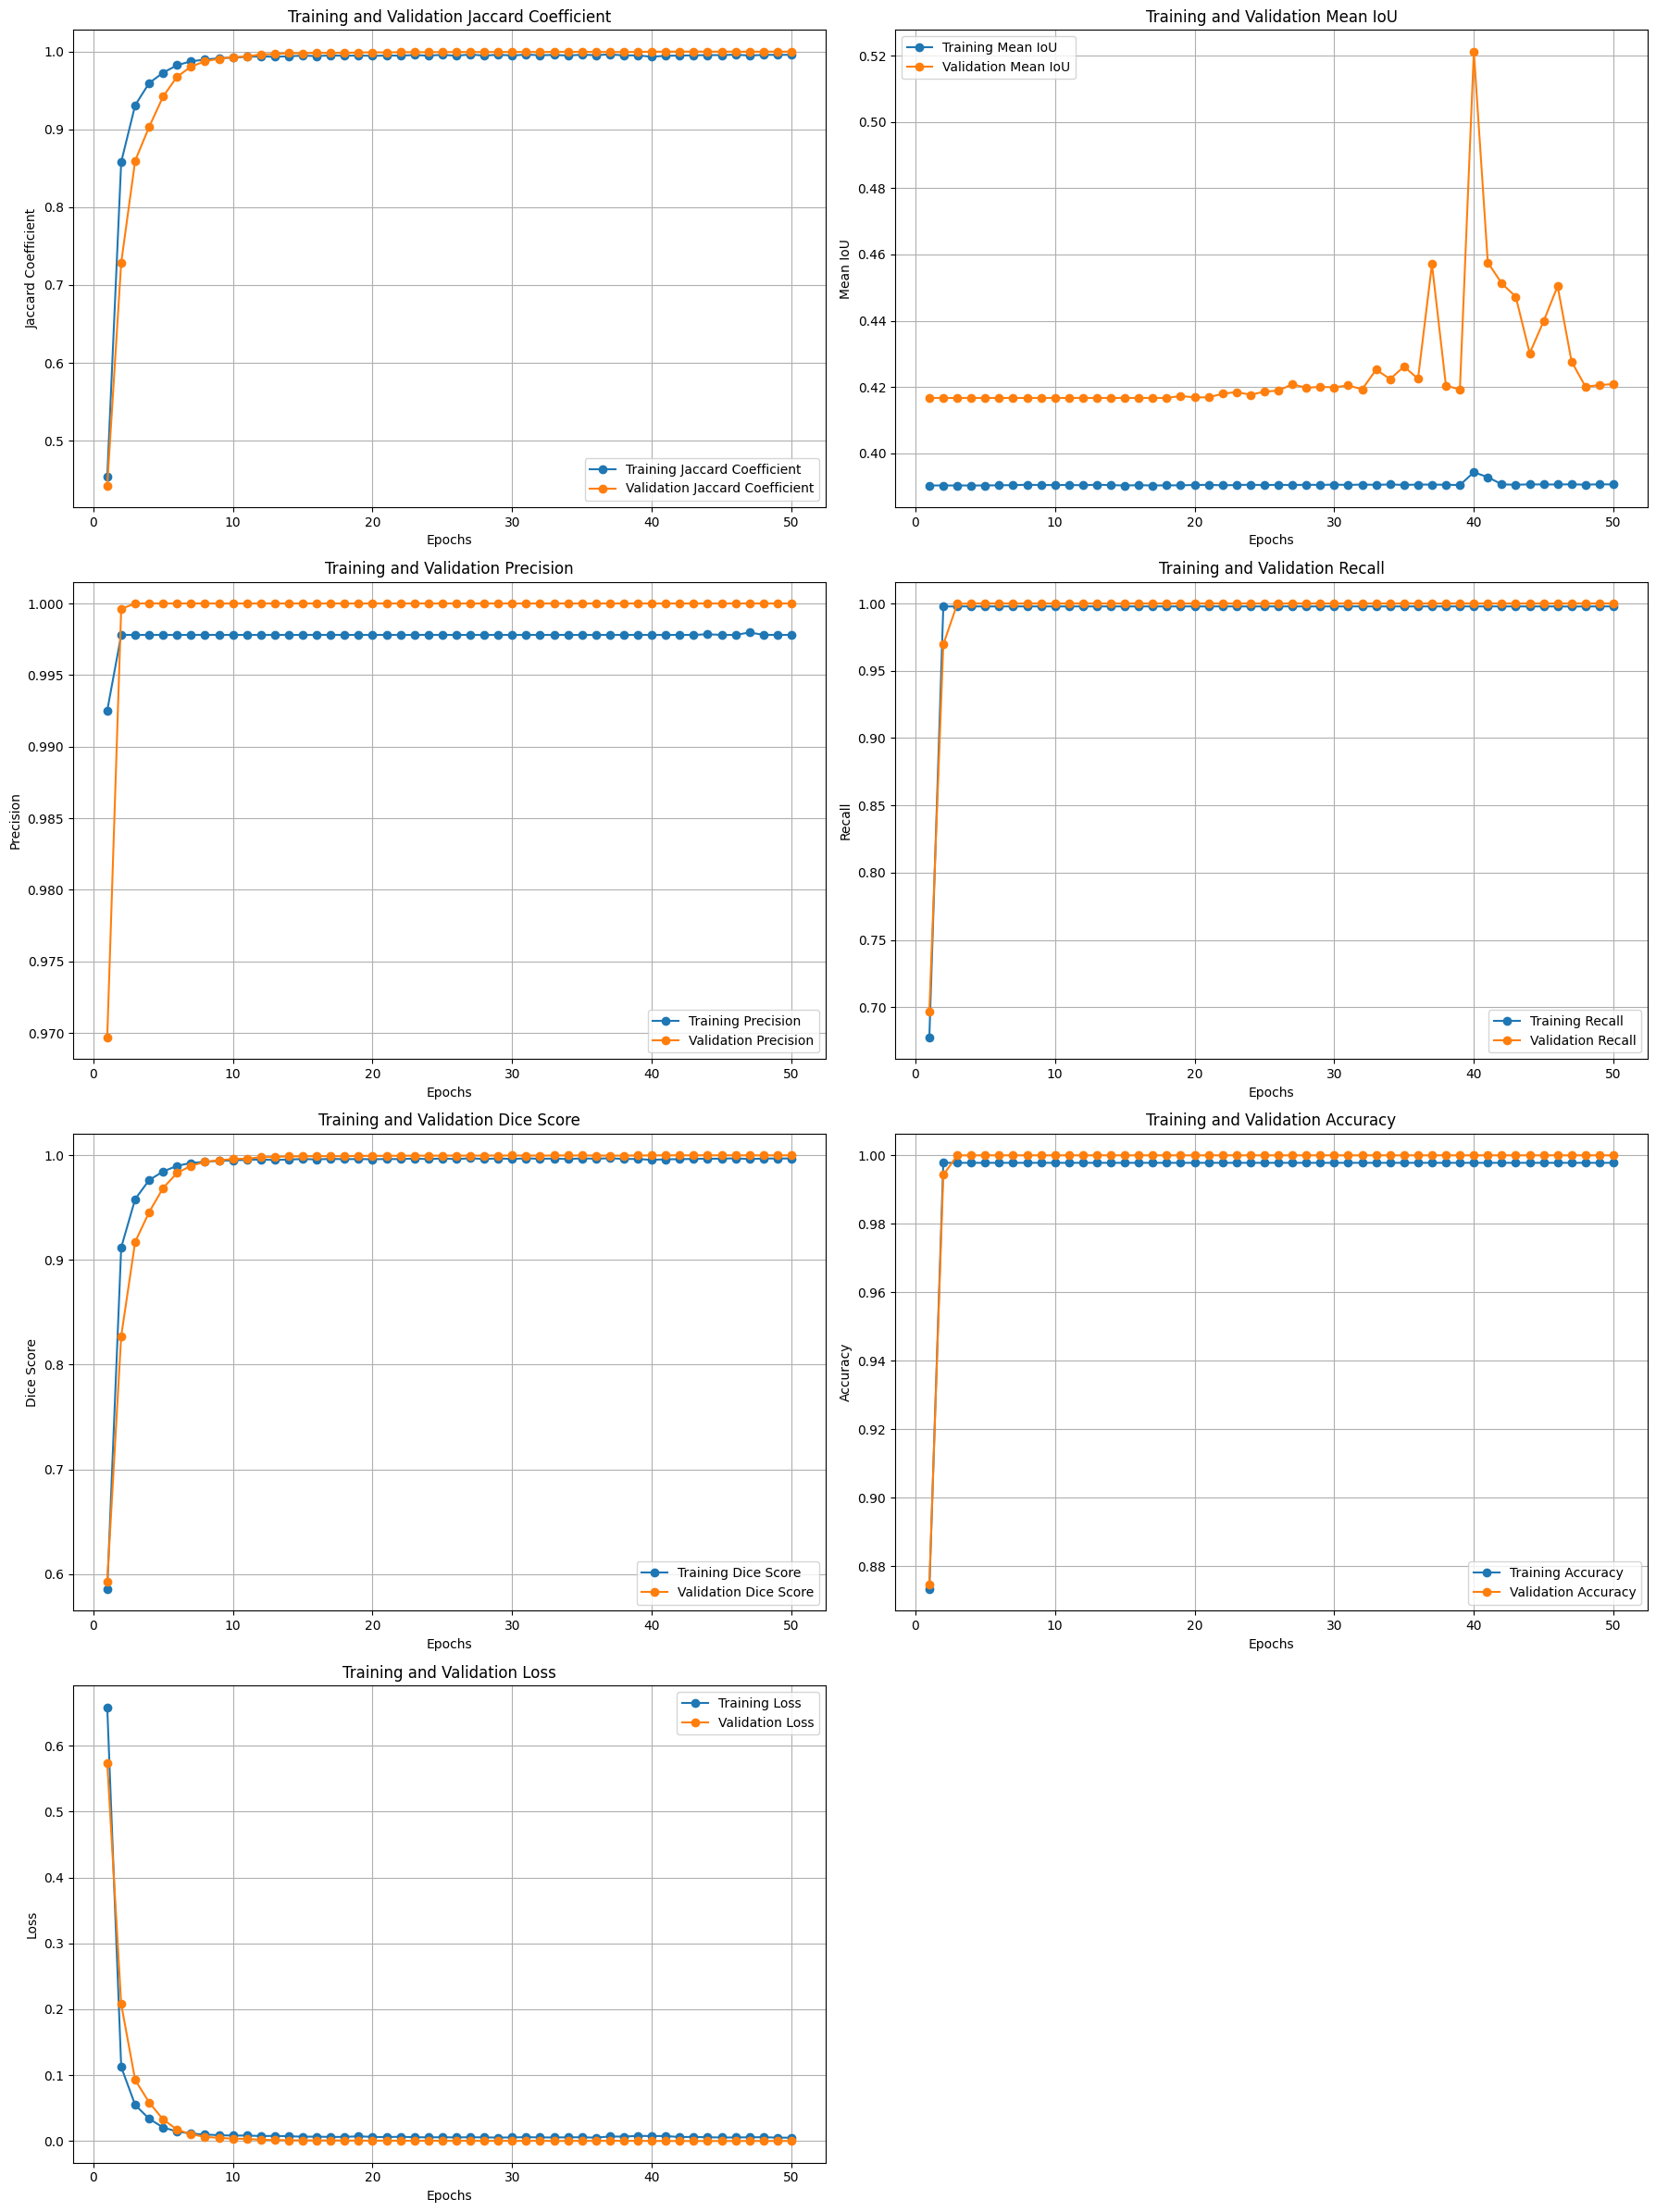

In [3]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 24))
    
    # Jaccard Coefficient
    plt.subplot(4, 2, 1)
    plt.plot(epochs, history.history['jaccard_coeff'], label='Training Jaccard Coefficient', marker= 'o')
    plt.plot(epochs, history.history['val_jaccard_coeff'],  label='Validation Jaccard Coefficient', marker= 'o')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.legend()
    plt.grid()

    # Mean IoU
    plt.subplot(4, 2, 2)
    plt.plot(epochs, history.history['mean_io_u'],  label='Training Mean IoU', marker= 'o')
    plt.plot(epochs, history.history['val_mean_io_u'],  label='Validation Mean IoU', marker= 'o')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid()

    # Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, history.history['precision'],  label='Training Precision', marker= 'o')
    plt.plot(epochs, history.history['val_precision'],  label='Validation Precision', marker= 'o')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

    # Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, history.history['recall'],  label='Training Recall', marker= 'o')
    plt.plot(epochs, history.history['val_recall'],  label='Validation Recall', marker= 'o')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    # Dice Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, history.history['dice_score'],  label='Training Dice Score', marker= 'o')
    plt.plot(epochs, history.history['val_dice_score'],  label='Validation Dice Score', marker= 'o')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(4, 2, 6)
    plt.plot(epochs, history.history['accuracy'],  label='Training Accuracy', marker= 'o')
    plt.plot(epochs, history.history['val_accuracy'],  label='Validation Accuracy', marker= 'o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(4, 2, 7)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker= 'o')
    plt.plot(epochs, history.history['val_loss'],  label='Validation Loss', marker= 'o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)

In [4]:
# Evaluate the model on the test set
test_results = ensemble_model.evaluate([X_test, X_test], Y_test, batch_size=batch_size, verbose=1)

# Define metric names
metric_names = ["Loss", "Mean IoU", "Precision", "Recall", "Jaccard Coefficient", "Dice Score", "Segmentation Accuracy"]

# Print formatted test results
print("\n📊 **Test Results:**")
for name, value in zip(metric_names, test_results):
    print(f"{name}: {value:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - dice_score: 0.9999 - jaccard_coeff: 0.9999 - loss: 5.3941e-05 - mean_io_u: 0.4238 - precision: 1.0000 - recall: 1.0000

📊 **Test Results:**
Loss: 0.0001
Mean IoU: 1.0000
Precision: 0.4209
Recall: 1.0000
Jaccard Coefficient: 1.0000
Dice Score: 0.9999
Segmentation Accuracy: 0.9999


In [8]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, MaxPooling2D, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

batch_size = 1

# Define dataset paths
train_dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
test_dataset_path = "/kaggle/input/satellite-image-and-mask"

# Function to load images and masks dynamically
def load_data(dataset_path, image_subfolder, mask_subfolder, img_size=(256, 256)):
    images, masks = [], []
    
    image_folder = os.path.join(dataset_path, image_subfolder)
    mask_folder = os.path.join(dataset_path, mask_subfolder)
    
    if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
        print(f"❌ Missing 'images' or 'masks' folder in {dataset_path}")
        return np.array([]), np.array([])

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    print(f"📂 Processing {dataset_path} - Found {len(image_files)} images, {len(mask_files)} masks")

    for img_name in image_files:
        img_path = os.path.join(image_folder, img_name)
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(mask_folder, mask_name)

        if not os.path.exists(mask_path):
            print(f"⚠️ Warning: No mask found for {img_name} (Skipping)")
            continue

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img / 255.0)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    print(f"✅ Loaded {len(images)} images and {len(masks)} masks from {dataset_path}")
    return images, masks

# Load datasets
X_train, Y_train = [], []
tiles = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5", "Tile 6", "Tile 7", "Tile 8"]
for tile in tiles:
    images, masks = load_data(os.path.join(train_dataset_path, tile), "images", "masks")
    if images.shape[0] > 0:
        X_train.append(images)
        Y_train.append(masks)

X_train = np.concatenate(X_train, axis=0) if X_train else np.array([])
Y_train = np.concatenate(Y_train, axis=0) if Y_train else np.array([])

X_test, Y_test = load_data(test_dataset_path, "test_image", "test_mask")

num_classes = 6
Y_train[Y_train >= num_classes] = num_classes - 1
Y_test[Y_test >= num_classes] = num_classes - 1

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

print(f"🔹 Training Data Shape: {X_train.shape}, {Y_train.shape}")
print(f"🔹 Testing Data Shape: {X_test.shape}, {Y_test.shape}")

# Define custom metrics
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    union = tf.reduce_sum(y_true + y_pred, axis=(-1))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

# Define DeepLabV3+ Model
def deeplabv3plus(input_shape=(256, 256, 3), num_classes=6):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output  

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax", dtype="float32")(x)
    return Model(base_model.input, outputs)

# Define UNet model
def unet(input_shape=(256, 256, 3), num_classes=6):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    up1 = UpSampling2D((2, 2))(conv2)
    outputs = Conv2D(num_classes, (1, 1), activation="softmax", dtype="float32")(up1)
    return Model(inputs, outputs)

# Initialize models
deeplabv3plus_model = deeplabv3plus()
unet_model = unet()

# Merge models
ensemble_output = Average()([deeplabv3plus_model.output, unet_model.output])
ensemble_model = Model(inputs=[deeplabv3plus_model.input, unet_model.input], outputs=ensemble_output)

# Particle Swarm Optimization (PSO) for learning rate tuning
def pso_optimize(model, X_train, Y_train, num_particles=5, num_iterations=3):
    best_lr = None
    best_loss = float('inf')
    particle_positions = np.random.uniform(low=0.00001, high=0.01, size=(num_particles,))
    
    for _ in range(num_iterations):
        for i in range(num_particles):
            lr = particle_positions[i]
            temp_model = Model(inputs=model.input, outputs=model.output)
            temp_model.compile(optimizer=Adam(learning_rate=lr), loss=CategoricalCrossentropy(), metrics=["accuracy"])
            history = temp_model.fit([X_train, X_train], Y_train, epochs=3, batch_size=batch_size, verbose=0)
            loss = history.history['loss'][-1]
            
            if loss < best_loss:
                best_loss = loss
                best_lr = lr
                
    return best_lr

optimal_lr = pso_optimize(ensemble_model, X_train, Y_train)
print(f"✅ Optimal Learning Rate found: {optimal_lr}")

# Compile model with optimal learning rate
ensemble_model.compile(
    optimizer=Adam(learning_rate=optimal_lr),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy", MeanIoU(num_classes=num_classes), Precision(), Recall(), dice_score, jaccard_coeff]
)

# Train model
history = ensemble_model.fit([X_train, X_train], Y_train, validation_data=([X_test, X_test], Y_test), epochs=50, batch_size=batch_size)



✅ GPU memory growth enabled
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 2 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 2
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 3 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 3
📂 Processing /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 4 - Found 9 images, 9 masks
✅ Loaded 9 images and 9 masks from /kaggle/input/semantic-segmentation-of-

<ipython-input-8-6552e1e26e25>:108: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


✅ Optimal Learning Rate found: 0.006345882761859501
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.9986 - dice_score: 0.9986 - jaccard_coeff: 0.9986 - loss: 0.0221 - mean_io_u_1: 0.9980 - precision_1: 0.9986 - recall_1: 0.9986 - val_accuracy: 1.0000 - val_dice_score: 1.0000 - val_jaccard_coeff: 1.0000 - val_loss: 1.1921e-07 - val_mean_io_u_1: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9917 - dice_score: 0.9917 - jaccard_coeff: 0.9917 - loss: 0.1345 - mean_io_u_1: 0.9896 - precision_1: 0.9917 - recall_1: 0.9917 - val_accuracy: 1.0000 - val_dice_score: 1.0000 - val_jaccard_coeff: 1.0000 - val_loss: 1.1921e-07 - val_mean_io_u_1: 0.9999 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9960 - dice_score: 0.9960 - jaccard_coeff: 0.9960 - loss: 0.0645 - mean_io_u_1: 0.9948 - precision_1: 0.9960 - recall_1: 0.9960 - val_accuracy: 1.0

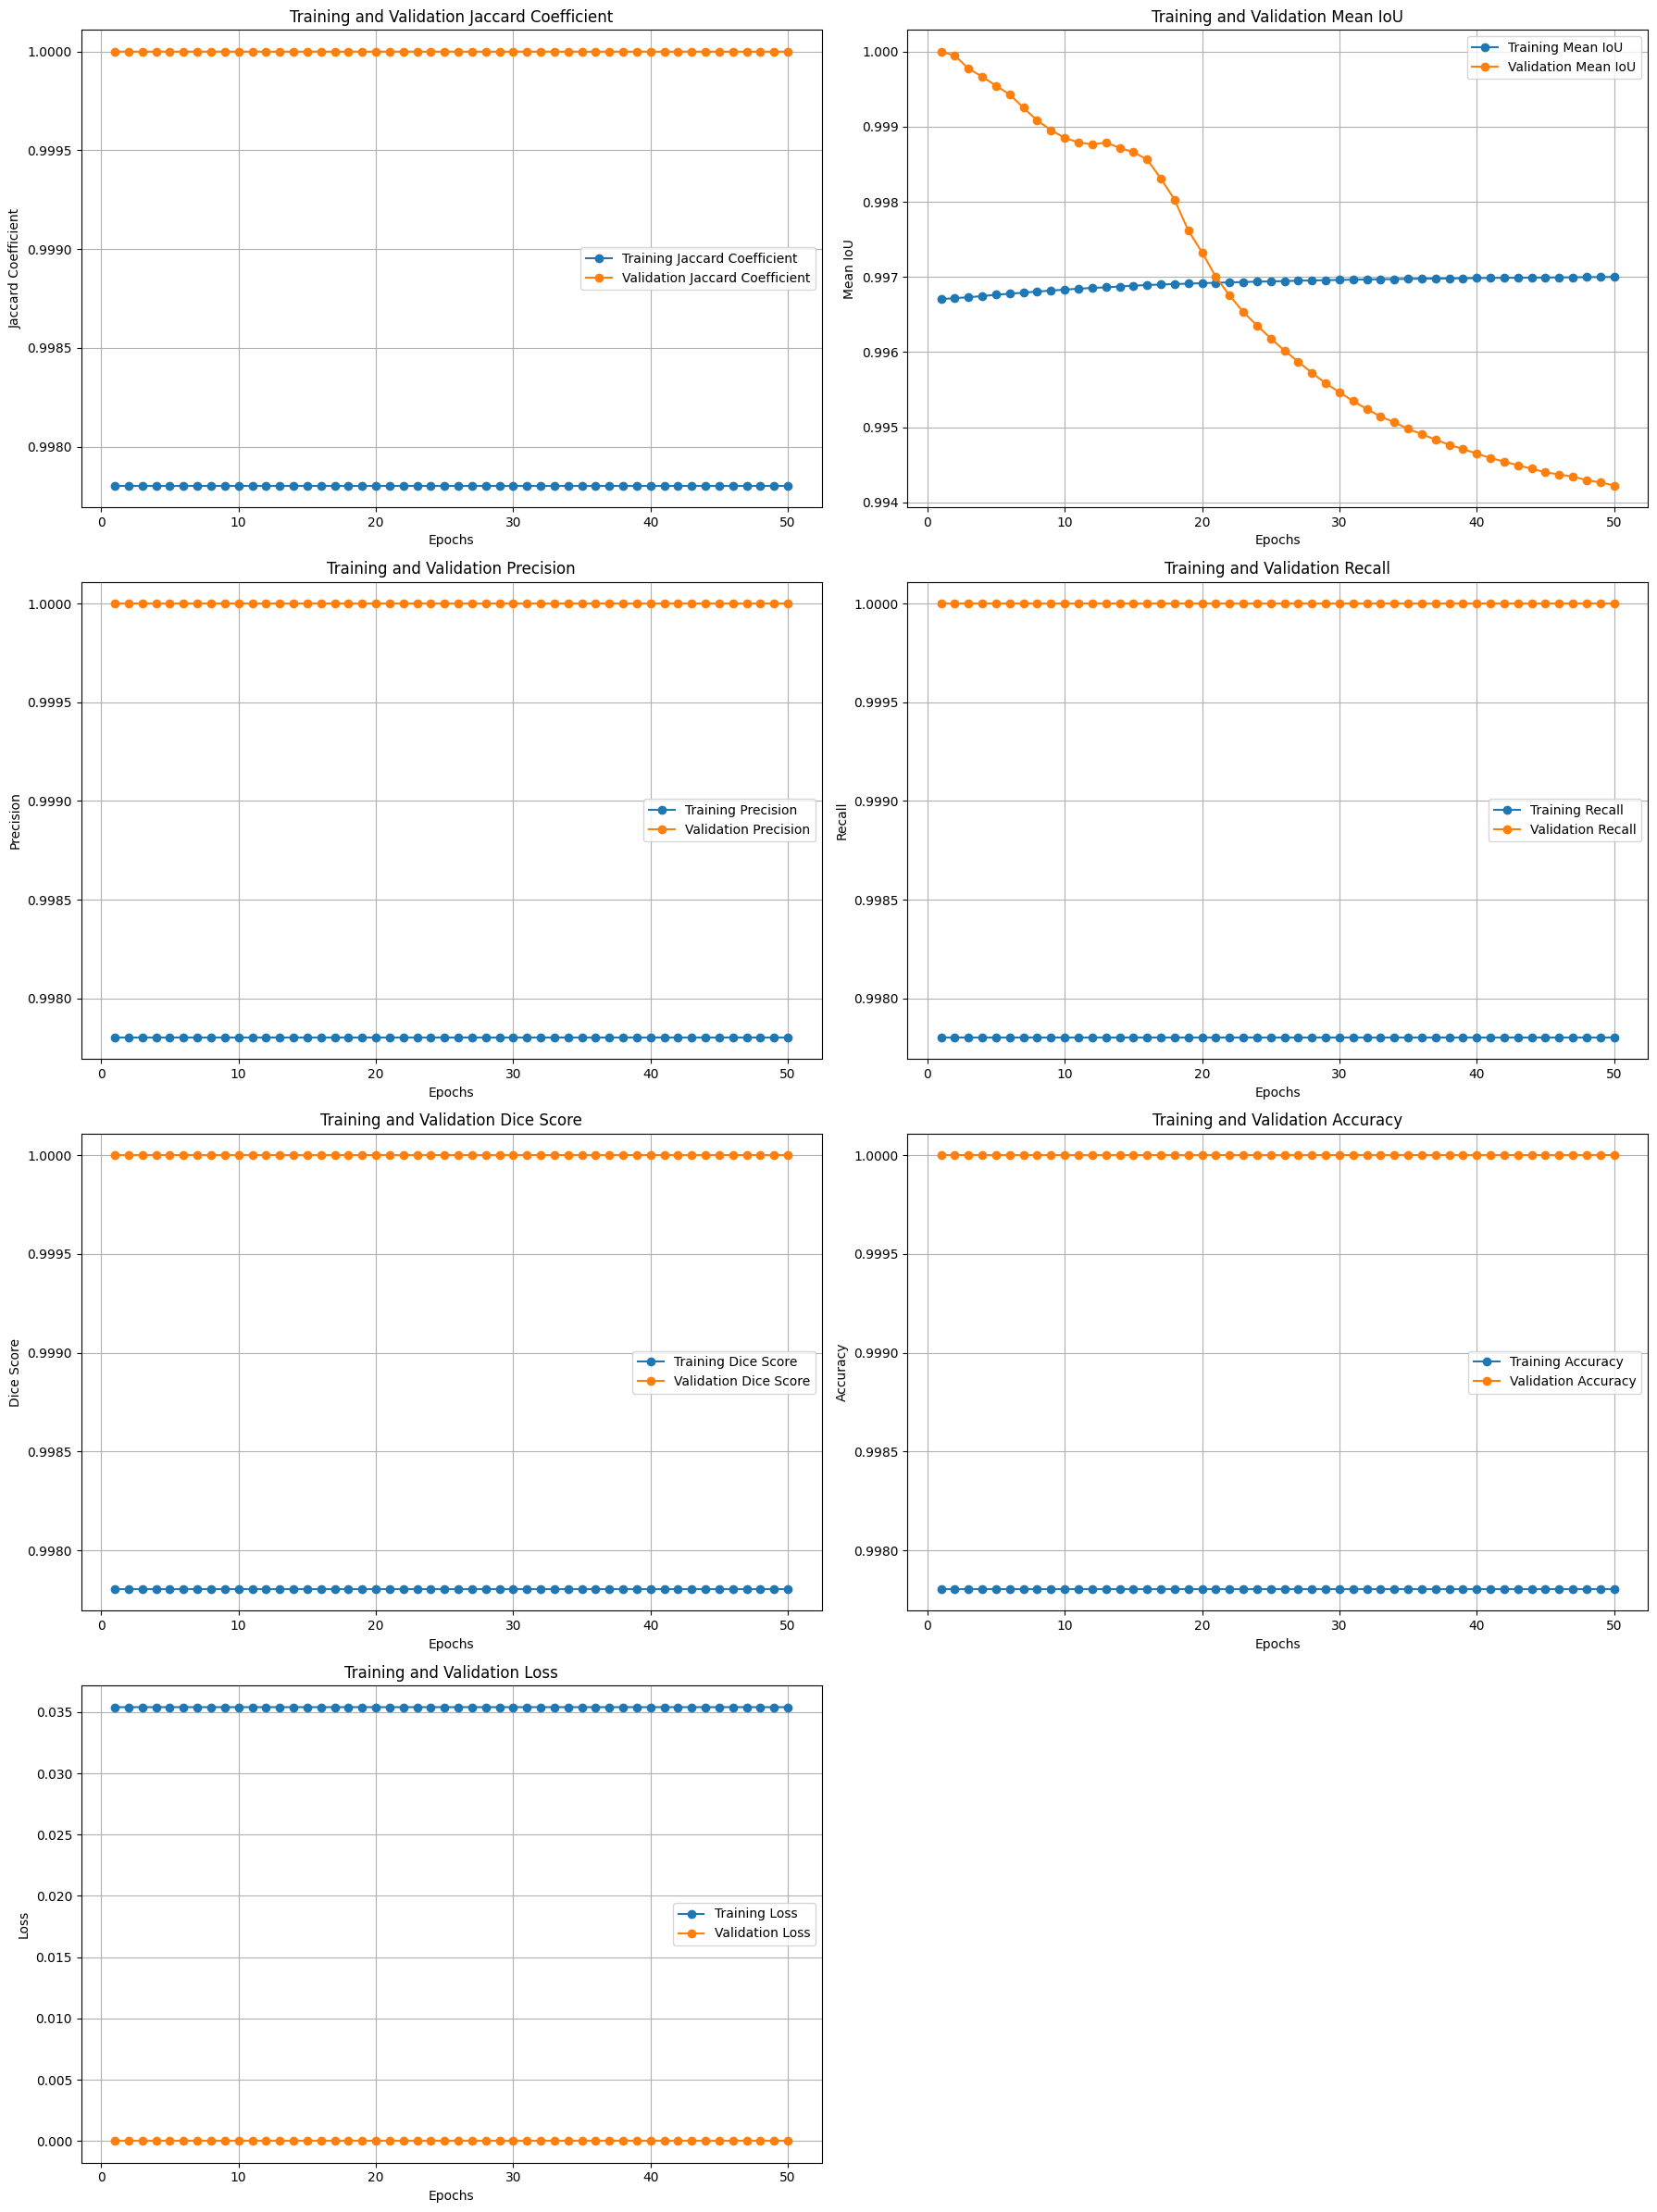

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 24))
    
    # Jaccard Coefficient
    plt.subplot(4, 2, 1)
    plt.plot(epochs, history.history['jaccard_coeff'], label='Training Jaccard Coefficient', marker= 'o')
    plt.plot(epochs, history.history['val_jaccard_coeff'],  label='Validation Jaccard Coefficient', marker= 'o')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.legend()
    plt.grid()

    # Mean IoU
    plt.subplot(4, 2, 2)
    plt.plot(epochs, history.history['mean_io_u_1'],  label='Training Mean IoU', marker= 'o')
    plt.plot(epochs, history.history['val_mean_io_u_1'],  label='Validation Mean IoU', marker= 'o')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid()

    # Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, history.history['precision_1'],  label='Training Precision', marker= 'o')
    plt.plot(epochs, history.history['val_precision_1'],  label='Validation Precision', marker= 'o')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

    # Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, history.history['recall_1'],  label='Training Recall', marker= 'o')
    plt.plot(epochs, history.history['val_recall_1'],  label='Validation Recall', marker= 'o')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    # Dice Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, history.history['dice_score'],  label='Training Dice Score', marker= 'o')
    plt.plot(epochs, history.history['val_dice_score'],  label='Validation Dice Score', marker= 'o')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(4, 2, 6)
    plt.plot(epochs, history.history['accuracy'],  label='Training Accuracy', marker= 'o')
    plt.plot(epochs, history.history['val_accuracy'],  label='Validation Accuracy', marker= 'o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(4, 2, 7)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker= 'o')
    plt.plot(epochs, history.history['val_loss'],  label='Validation Loss', marker= 'o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)

In [10]:
# Evaluate the model on the test set
test_results = ensemble_model.evaluate([X_test, X_test], Y_test, batch_size=batch_size, verbose=1)

# Define metric names
metric_names = ["Loss", "Mean IoU", "Precision", "Recall", "Jaccard Coefficient", "Dice Score", "Segmentation Accuracy"]

# Print formatted test results
print("\n📊 **Test Results:**")
for name, value in zip(metric_names, test_results):
    print(f"{name}: {value:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - dice_score: 1.0000 - jaccard_coeff: 1.0000 - loss: 1.3752e-07 - mean_io_u_1: 0.9974 - precision_1: 1.0000 - recall_1: 1.0000

📊 **Test Results:**
Loss: 0.0000
Mean IoU: 1.0000
Precision: 0.9942
Recall: 1.0000
Jaccard Coefficient: 1.0000
Dice Score: 1.0000
Segmentation Accuracy: 1.0000
